In [100]:
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.utils import class_weight


In [101]:
NUMBER_OF_CLASSES = 6
EPOCHS = 50

TRAINING_PATH = "../data_collection/datasets/training"
TEST_PATH = "../data_collection/datasets/test"

x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-900:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-900:]

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
class_weights = tf.cast(tf.constant(class_weights), "float32")

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



In [102]:
def weightedLoss(weights=tf.constant([1,1,1,1,1])):
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [103]:

def create_mlp_model(input_shape:Tuple[int, int], 
                     layer_number:int, 
                     neuron_number:List[int], 
                     activation:str|None="relu",
                     loss:str|None = "mae",
                     optimizer:str|None="adam") -> tf.keras.Model:

    """Creates a simple MLP regression model with 3-layers."""
    print(loss)

    layers = [tf.keras.layers.Dense(neuron_number[i], activation=activation) for i in range(layer_number)]
    layers.insert(0, tf.keras.layers.InputLayer(input_shape=input_shape))
    layers.insert(1, tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax"))
    # layers.append(tf.keras.layers.Maximum())

    model = tf.keras.Sequential(layers)
    model.compile(
        # loss=loss,
        loss=weightedLoss(class_weights),
        optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.009),
        metrics=["acc"]
    )

    return model

In [104]:
import platform
print(platform.platform())
tf.config.list_physical_devices('GPU')

macOS-13.3.1-arm64-arm-64bit


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [105]:
model = create_mlp_model(INPUT_DIM, 10, [128, 64, 32, 128, 64, 32, 128, 64 ,32, 16], activation="tanh", loss="categorical_crossentropy", optimizer="adam")

categorical_crossentropy


In [106]:
## model training 
history = model.fit(x_training, y_training, epochs=EPOCHS, batch_size=64, verbose=1, validation_split=0.10)

Epoch 1/50
13/13 [==============================] - 1s 37ms/step - loss: 1.8075 - acc: 0.1963 - val_loss: 1.7749 - val_acc: 0.2444
Epoch 2/50
13/13 [==============================] - 0s 12ms/step - loss: 1.7842 - acc: 0.2198 - val_loss: 1.7288 - val_acc: 0.2444
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 1.7786 - acc: 0.2099 - val_loss: 1.7584 - val_acc: 0.1556
Epoch 4/50
13/13 [==============================] - 0s 10ms/step - loss: 1.7716 - acc: 0.2148 - val_loss: 1.8687 - val_acc: 0.1000
Epoch 5/50
13/13 [==============================] - 0s 12ms/step - loss: 1.7674 - acc: 0.2259 - val_loss: 1.7120 - val_acc: 0.2778
Epoch 6/50
13/13 [==============================] - 0s 13ms/step - loss: 1.7635 - acc: 0.2123 - val_loss: 1.8245 - val_acc: 0.1778
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 1.7641 - acc: 0.2358 - val_loss: 1.7797 - val_acc: 0.1889
Epoch 8/50
13/13 [==============================] - 0s 10ms/step - loss: 1.7599 - a

In [107]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 828)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               106112    
                                                                 
 dense_57 (Dense)            (None, 64)                8256      
                                                                 
 dense_58 (Dense)            (None, 32)                2080      
                                                                 
 dense_59 (Dense)            (None, 128)               4224      
                                                                 
 dense_60 (Dense)            (None, 64)                8256      
                                                                 
 dense_61 (Dense)            (None, 32)              

In [108]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

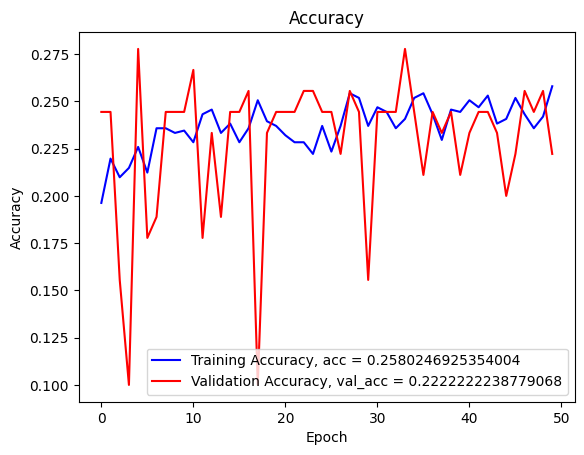

In [109]:
plt.plot(range(EPOCHS), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(EPOCHS), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

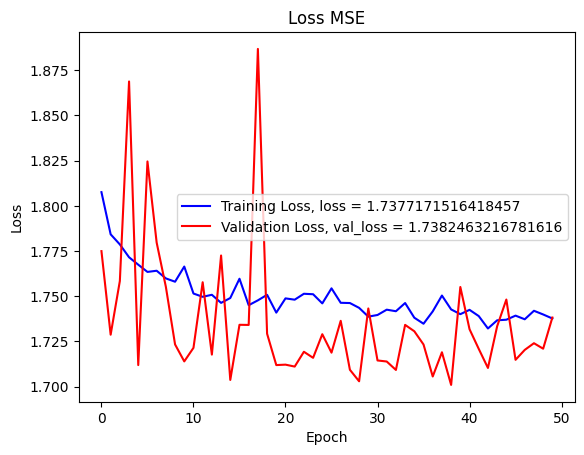

In [110]:
plt.plot(range(EPOCHS), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(EPOCHS), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [94]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)  

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))

In [95]:
y_test

<tf.Tensor: shape=(395,), dtype=int32, numpy=
array([3, 0, 3, 3, 0, 1, 4, 2, 1, 4, 0, 1, 1, 0, 0, 4, 0, 0, 2, 2, 3, 0,
       3, 0, 3, 1, 2, 3, 1, 2, 2, 0, 1, 3, 2, 4, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 4, 2, 2, 1, 4, 3, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 1, 1, 1, 4, 4, 3, 4, 2, 4, 2, 2, 3,
       1, 2, 3, 0, 2, 4, 4, 2, 2, 2, 1, 2, 2, 2, 4, 1, 2, 4, 1, 4, 2, 3,
       2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 3, 0, 2, 1, 4, 2, 2, 2, 2, 2,
       2, 3, 1, 3, 2, 4, 3, 2, 1, 0, 3, 0, 1, 2, 0, 3, 1, 0, 4, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 4, 1, 4, 4, 0, 4, 4, 1, 2, 2, 0, 2, 4, 2, 0, 2, 0,
       0, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3,
       2, 2, 1, 3, 2, 2, 1, 3, 2, 2, 2, 2, 3, 2, 1, 0, 3, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 3, 4, 3, 4, 3, 4,
       4, 2, 3, 2, 0, 4, 4, 1, 2, 2, 0, 4, 2, 2, 1, 4, 0, 2, 4, 2, 3, 2,
     

In [96]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 8ms/step - loss: 1.3841 - acc: 0.4835


[1.3841243982315063, 0.4835442900657654]

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

In [98]:
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax (y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

13/13 [==============================] - 0s 4ms/step
[[0.         0.         0.10632911 0.         0.        ]
 [0.         0.         0.1443038  0.         0.        ]
 [0.         0.         0.4835443  0.         0.        ]
 [0.         0.         0.12911392 0.         0.        ]
 [0.         0.         0.13670886 0.         0.        ]]


In [99]:
np.unique(y_prediction, return_counts=True)

(array([2]), array([395]))

In [170]:
y_prediction.shape

(395,)

In [175]:
y_prediction[200:300]

array([0, 0, 0, 0, 0, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 0, 3, 0, 3, 3, 3])

In [34]:
np.unique(y_training, return_counts=True)

(array([2.], dtype=float32), array([1578]))